# Core functionality tutorial
This notebook will go over each primitive in the package and show their intended use.

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from hierarqcal import (
    Qhierarchy,
    Qcycle,
    Qpermute,
    Qpivot,
    Qmask,
    Qunmask,
    Qinit,
    Qmotif,
    Qmotifs,
    Qsplit,
    plot_motif,
    Qunitary,
    plot_circuit,
)

## Specify backend
It is possible to use the package without a specific backend, but we choose one here for visualisation purposes. We're mainly going to use the backends plotting functionality to display the circuits, so pick the one you have installed.

In [3]:
backend = "qiskit"

In [4]:
if backend == "qiskit":
    import qiskit
    from hierarqcal.qiskit.qiskit_circuits import V2, U2, V4

    def get_circuit(hierq):
        return hierq(backend="qiskit")

    def draw_circuit(circuit, **kwargs):
        return circuit.draw(output="mpl", **kwargs)

elif backend == "cirq":
    import cirq
    from cirq.contrib.svg import SVGCircuit
    from hierarqcal.cirq.cirq_circuits import V2, U2, V4
    import logging
    logging.getLogger('matplotlib.font_manager').disabled = True
    def get_circuit(hierq):
        return hierq(backend="cirq")

    def draw_circuit(circuit, **kwargs):
        return SVGCircuit(circuit, **kwargs)

elif backend == "pennylane":
    import pennylane as qml
    from hierarqcal.pennylane.pennylane_circuits import V2, U2, V4

    def get_circuit(hierq):
        dev = qml.device("default.qubit", wires=hierq.tail.Q)

        @qml.qnode(dev)
        def circuit():
            if isinstance(next(hierq.get_symbols(), False), sp.Symbol):
                # Pennylane doesn't support symbolic parameters, so if no symbols were set (i.e. they are still symbolic), we initialize them randomly
                hierq.set_symbols(np.random.uniform(0, 2 * np.pi, hierq.n_symbols))
            hierq(
                backend="pennylane"
            )  # This executes the compute graph in order
            return [qml.expval(qml.PauliZ(wire)) for wire in hierq.tail.Q]

        return circuit

    def draw_circuit(circuit, **kwargs):
        fig, ax = qml.draw_mpl(circuit)(**kwargs)

## Building blocks
Circuit architectures are created by stacking motifs hierarchacially, the lowest level motifs (primitives) are building blocks for higher level ones. On a high level you can regard a primitive as a layer capturing some design motif (cycle, mask, etc) and we're creating a sequence of layers for the circuit. This view only captures hierarchical architectures of two levels (*level 1 -> primitives, level 2 -> sequence of primitves*). The framework is more general in that there is no limit to the number of levels used to represent an architecture. See the comparison below:

**Layer view**
 - architecture = (Cycle, Mask, Cycle, Mask, Cycle, Cycle, Cycle, Mask, Cycle, Mask)

**Hierarchical view**
 - m2_1 = (Cycle, Mask)
 - m2_2 = (Cycle, Cycle)
 - m3_1 = (m2_1, m2_1)
 - architecture = (m3_1, m2_2, m3_1)

 <img src="https://github.com/matt-lourens/hierarqcal/blob/master/img/hierarchical_motifs.drawio.png?raw=true" >
 Consider the figure above, to create the architecture on the right we want to **repeat the alternation between a cycle of stride 1 and masking from bottom to top three times**. The semantic description is simple and intuitive, the package is designed to allow building circuits this way. Notice a cycle of stride 1 and masking from bottom to top are both primitves. Alternating between them, is a level two motif (p1+p2), then repeating that 3 times is a level 3 motif. This gives a concise description of the circuit on the right. The circuit being a binary tree architecture (which is hierarchical).

There are two main classes to generate circuit architectures: `Qhierarchy` and `Qmotif`. We call our building blocks primitives, all are instances of `Qmotif`. A primitive is a directed graph with nodes representing qubits and edges unitaries applied between them. The edges are determined by its rules and the number of available qubits. Primitives are stacked with addition or mutliplication operations which act as append and extend, ex: `Qcycle()+Qpermute() = (Qcycle,Qpermute)` which is a `Qmotifs` object, a sequence of `Qmotif`. Simlarly `Qcycle()*3 = (Qcycle(), Qcycle(), Qcycle)` is again an instance of `Qmotifs`. Note it's possible to add motifs together without specifying qubits, when you have a motif ready, it's initialized with `Qinit` in the following way: `Qinit(8)+motif`. This creates a `Qhierarchy` object, which runs through all the motifs generates their edges.

 The types of primitves are:
 - `Qcycle`: Create a cycle of unitaries, sometimes called `ladders` or `convolutions`. It's hyperparamaters are used to generate cycles in directed graphs
 - `Qpermute`: unitaries permuted across qubits.
 - `Qmask`: Mask certain qubits based on a pattern, a mapping can be provided to *save* it's information. Also reffered to as `entanglers` or `pooling` layers.
 - `Qunmask`: Unmask previously masked unitaries
 - `Qinit`: specify the qubit names, order and amount.

### Qunitary
The edges of primitves encode the connectivity of the unitary, 1-qubit unitaries correspond to edges with arity 1 (1-ary tuples primitive.E=[(1,),(2),,...]). 2 qubit unitaries correspond to 2-ary tuples primitive.E=[(1,2),(3,4),...] and `N`-qubit unitaries to N-ary tuples ex: primitive.E=[(1,2,...,7),(3,4,...,8),...]. `Qunitary` tells a primitive the arity of it's operation, each primitive has a mapping hyperparamater that expects a `Qunitary` object. The arguments for `Qunitary` are:

 - function: the function that get's executed at every edge
 - n_symbols: the number of symbols the function expects
 - arity: the arity of the function (number of qubits it acts upon)

Notice that any function is permitted, there is no restriction to unitarity or even quantumness. In this sense the package is a dynamic datatrstructe to construct of hierarchichal compute graphs, but we work mainly in the context of quantum computing. This is also why the packages is framework agnostic, since no matter the framework, you will be able to create a function that does it's circuit execution. HierarQcal manages the order in which these circuits get executed (well it generates the order, and number of executions.). For creating architectures, we only need to know the arity and number of symbols our function expects. This way, you can generate a circuit architecture without specifying the specific function corresponding to a unitary and framework. Once the architecture is ready, you can specify the functions and execute it on a backend by calling `hierq(backend="qiskit")` where `hierq` is the `Qhierarchy` object containing the architecture (or more generally, the compute graph).

For the examples below, we specify an arbitrary `Qunitary` object with no specific function connected to it:

In [5]:
u0_1 = Qunitary(function=None, n_symbols=0, arity=1)
u0_2 = Qunitary(function=None, n_symbols=0, arity=2)
u1_2 = Qunitary(function=None, n_symbols=1, arity=2)
u2_3 = Qunitary(function=None, n_symbols=2, arity=3)
u2_4 = Qunitary(function=None, n_symbols=2, arity=4)

### Qinit primitive
`Qinit` is a special primitive with no operational effect. It initializes a set of qubit labels as reference for operations. `Qinit` is always provided at the start of a statement ex: `Qinit(3)+motifs` which causes a `Qhierarchy` object to be created. `Qhierarchy` manages the edge creation of motifs. Use `Qinit` is usually used in the final statement combining all motifs into an architecture or in statements that create sub hierarchies. Providing an integer $n$ labels the qubits $1, 2, \dots, n$, but providing a list with specific qubit order is also possible:

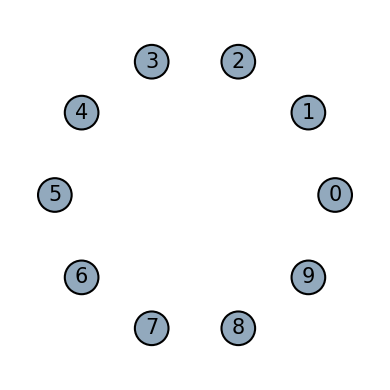

In [6]:
init_primitive = Qinit(10)
fig, ax = plot_motif(init_primitive)

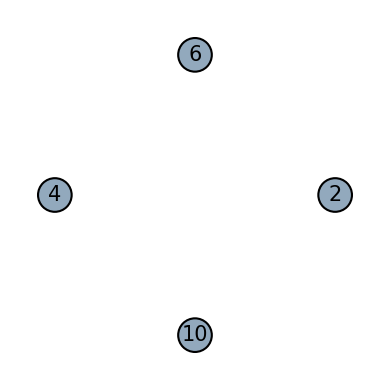

In [7]:
init_primitive = Qinit([2,6,4,10])
fig, ax = plot_motif(init_primitive)

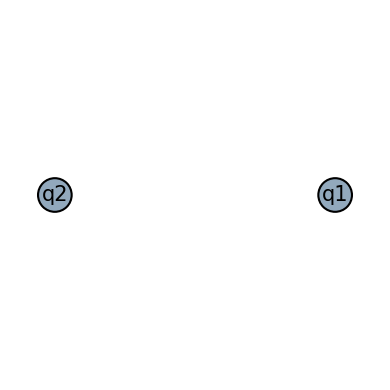

In [8]:
init_primitive = Qinit(["q1", "q2"])
fig, ax = plot_motif(init_primitive)

### Cycle primitive
`Qcycle` is a primitve that creates a cycle or ladder or convolution of unitaries. It has four main hyperparameters:
 - `stride`: The number of nodes to skip, before connecting the edge
 - `step`: The number of nodes to step over after the edge was connected
 - `offset`: The node to start the procedure with
 - `boundary`: The boundary condition of the cycle, can be `open` or `periodic`
The action is best seen through examples, but the general procedure for edge creation is staring at `offset` step in units of `step` at each `step` connect to `stride` units away.

In [9]:
# Convolution of stride 3, try out other stride values
cycle = Qcycle(stride=5, mapping=u1_2)
cycle_on_8_qubits = Qinit(8) + cycle

# Note the type of 'conv_on_8_qubits', it's a qcnn with two motifs: (Qfree, Qconv)
print(f"Type of object\t {type(cycle_on_8_qubits)}")
print(f"First motif\t {type(cycle_on_8_qubits.tail)}")
print(f"Second motif\t {type(cycle_on_8_qubits.tail.next)}")

Type of object	 <class 'hierarqcal.core.Qhierarchy'>
First motif	 <class 'hierarqcal.core.Qinit'>
Second motif	 <class 'hierarqcal.core.Qcycle'>


(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

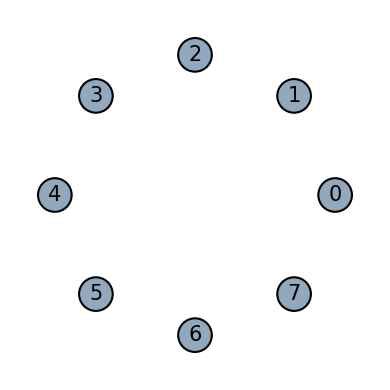

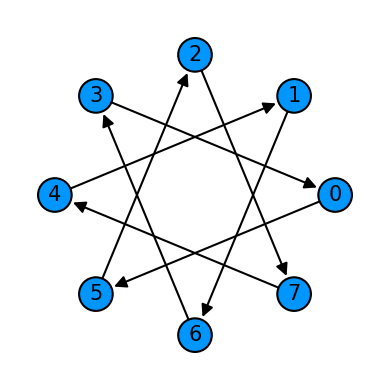

In [10]:
plot_motif(cycle_on_8_qubits[0])
plot_motif(cycle_on_8_qubits[1])

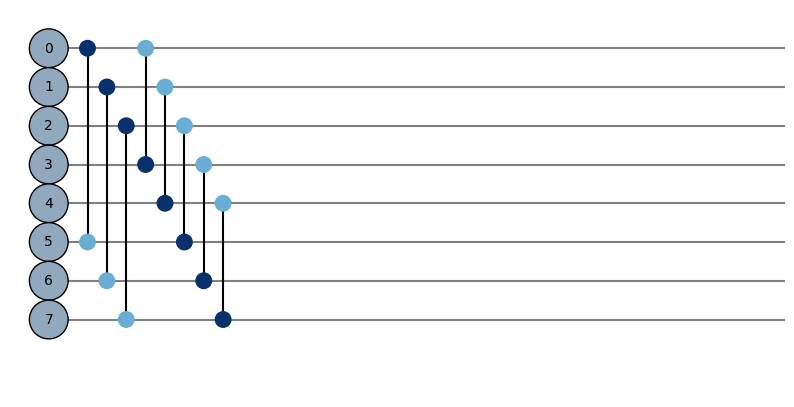

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [11]:
# There is a minimal circuit plotter which converts the sequence of digraph into a two dimensional view.
# Notice no specific unitary needs to be specified, it's seen as a black box where we're only building the connectivity.
plot_circuit(cycle_on_8_qubits)

#### Stride examples

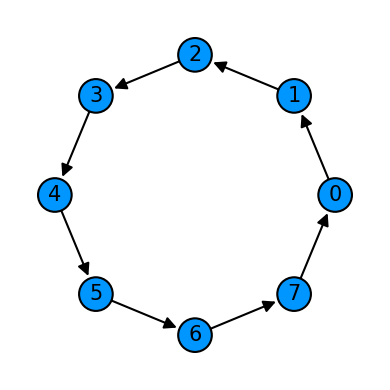

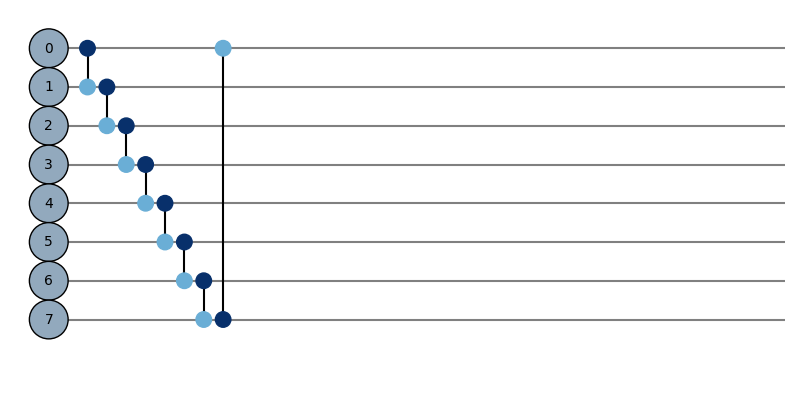

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [12]:
cycle = Qcycle(stride=1, step=1,offset=0, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])
plot_circuit(cycle)

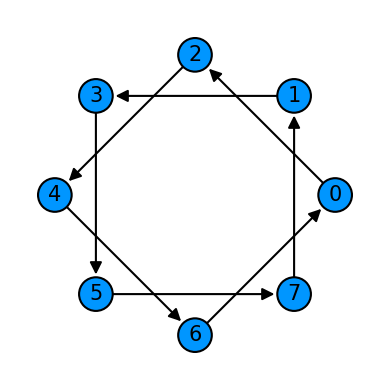

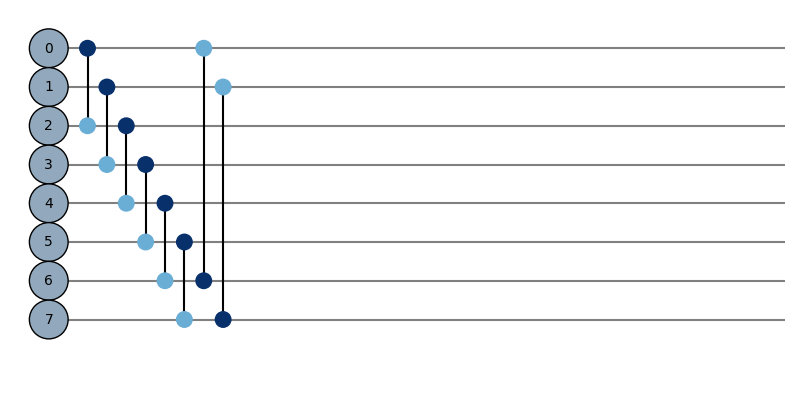

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [13]:
cycle = Qcycle(stride=2, step=1,offset=0, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])
plot_circuit(cycle)

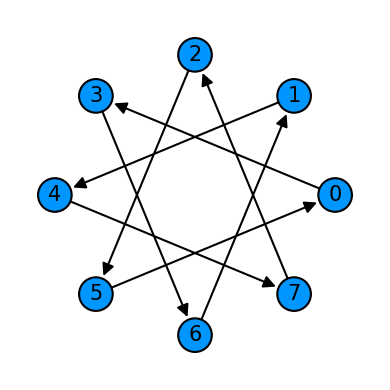

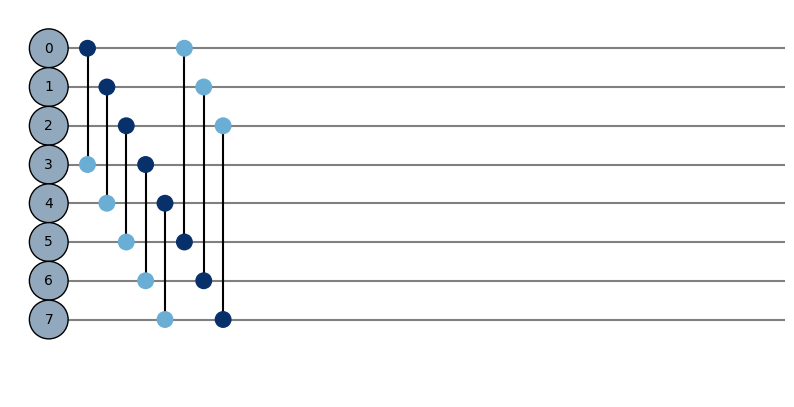

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [14]:
cycle = Qcycle(stride=3, step=1,offset=0, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])
plot_circuit(cycle)

#### Step examples

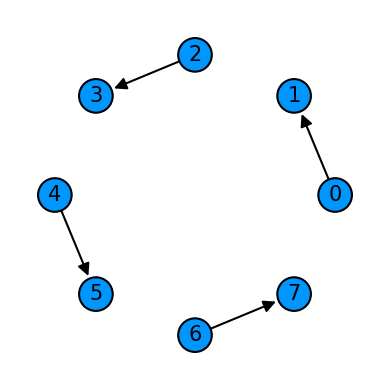

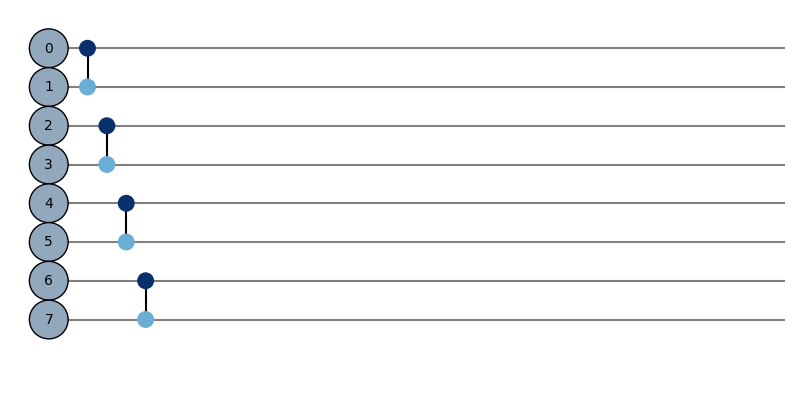

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [15]:
cycle = Qcycle(stride=1, step=2,offset=0, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])
plot_circuit(cycle)

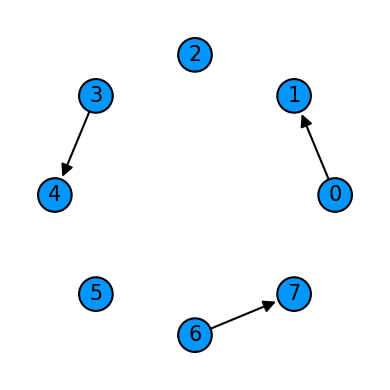

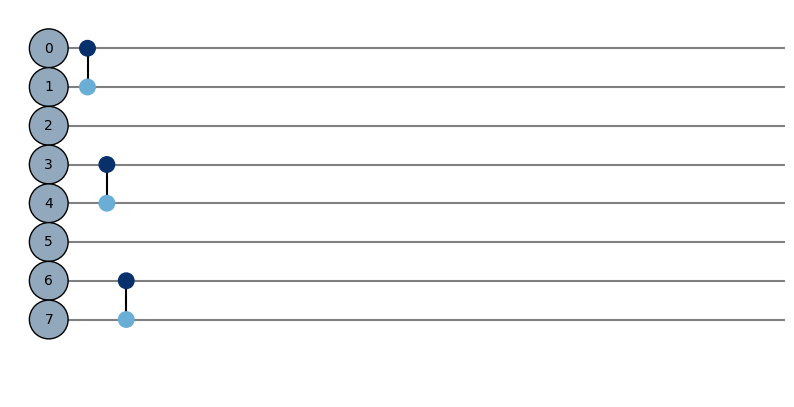

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [16]:
cycle = Qcycle(stride=1, step=3,offset=0, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])
plot_circuit(cycle)

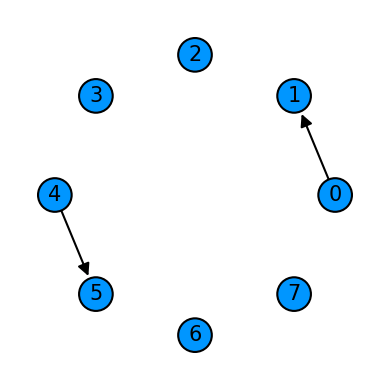

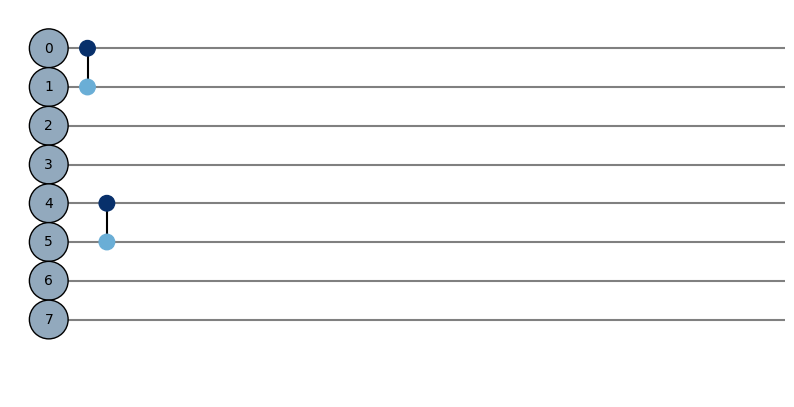

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [17]:
cycle = Qcycle(stride=1, step=4,offset=0, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])
plot_circuit(cycle)

#### Offset examples

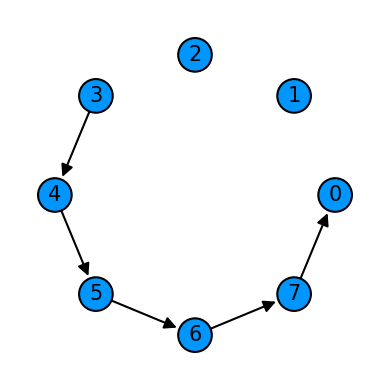

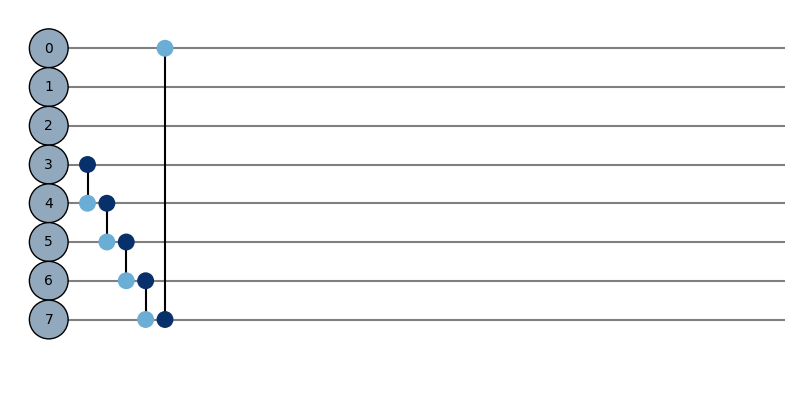

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [18]:
cycle = Qcycle(stride=1, step=1,offset=3, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])
plot_circuit(cycle)

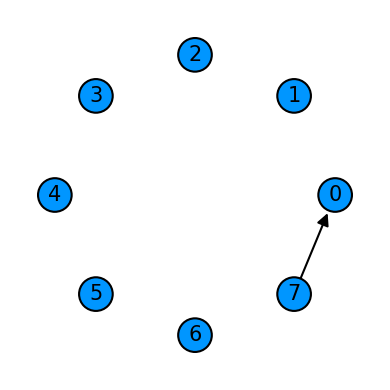

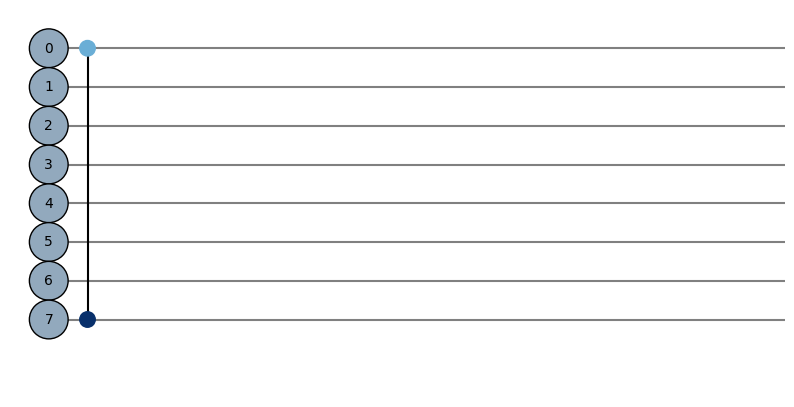

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [19]:
cycle = Qcycle(stride=1, step=1,offset=7, mapping=u1_2)
cycle = Qinit(8) + cycle
plot_motif(cycle[1])
plot_circuit(cycle)

#### Boundary examples

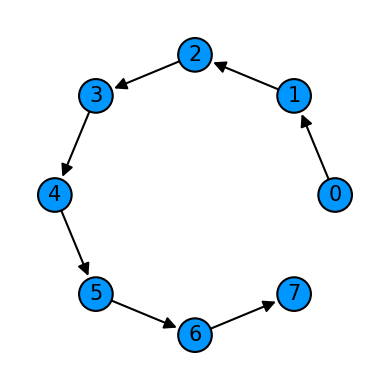

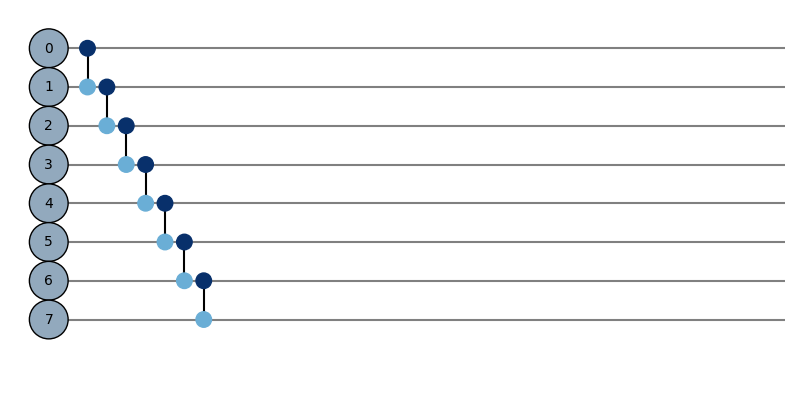

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [20]:
cycle = Qcycle(stride=1, step=1,offset=0, mapping=u1_2, boundary="open")
cycle = Qinit(8) + cycle
plot_motif(cycle[1])
plot_circuit(cycle)

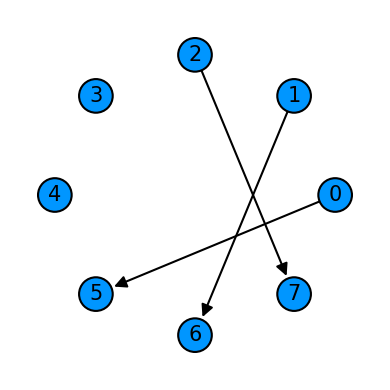

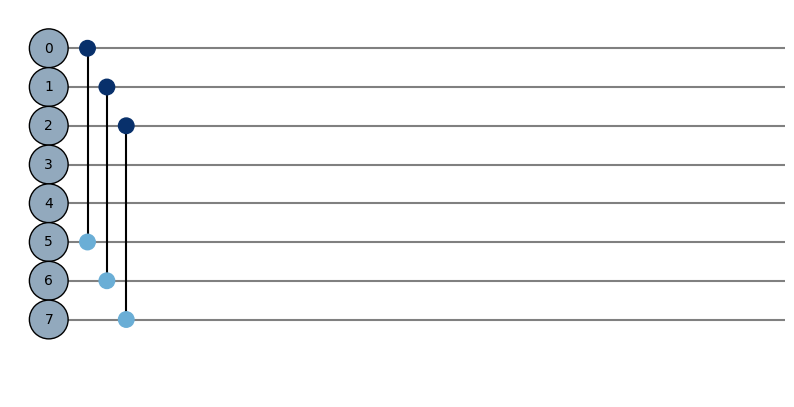

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [21]:
cycle = Qcycle(stride=5, step=1,offset=0, mapping=u1_2, boundary="open")
cycle = Qinit(8) + cycle
plot_motif(cycle[1])
plot_circuit(cycle)

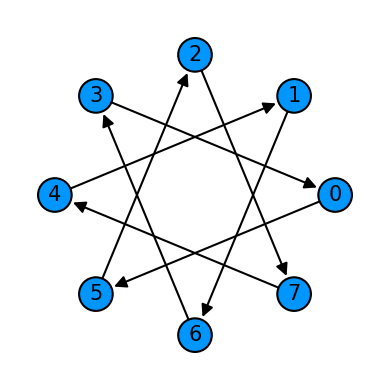

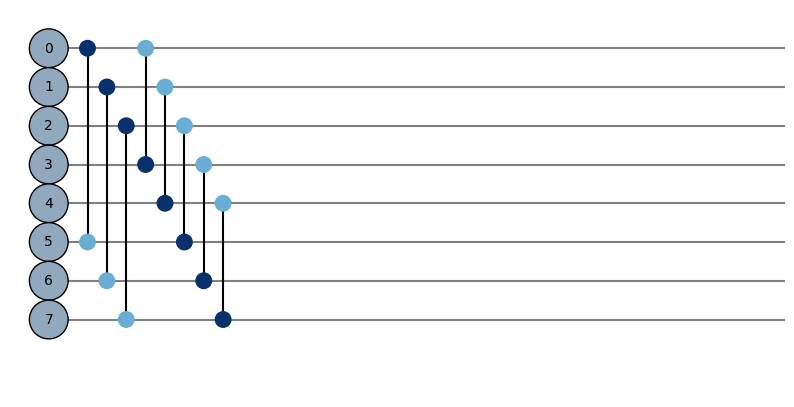

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [22]:
cycle = Qcycle(stride=5, step=1,offset=0, mapping=u1_2, boundary="periodic")
cycle = Qinit(8) + cycle
plot_motif(cycle[1])
plot_circuit(cycle)

#### N qubit unitaries
For N-qubit unitaries other than N=2, the cycle primitive becomes a hypergraph. `stride`, `step` and `offset` still has the same meaning but now the edges are N-ary tuples. For example a stride of 3 causes edges of the form (1,4,7) for a 3-qubit unitary. This means the function gets sent bits 1,4,7 in that order. Consider the same 3 qubit unitary defined with pennylane, qiskit or cirq

In [23]:
if backend == "qiskit":
    from qiskit.circuit import QuantumRegister
    def U3(bits, symbols=None, circuit=None, **kwargs):
        q0, q1, q2 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1]), QuantumRegister(1, bits[2])
        circuit.crz(symbols[0], q0, q1)
        circuit.crx(symbols[1], q2, q1)
        return circuit

elif backend == "cirq":
    import cirq
    def U3(bits, symbols=None, circuit=None):
        q0, q1, q2 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1]), cirq.LineQubit(bits[2])
        circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
        circuit += cirq.rx(symbols[1]).on(q1).controlled_by(q2)
        return circuit

elif backend == "pennylane":
    def U3(bits, symbols=None):
        qml.CRZ(symbols[0], wires=[bits[0], bits[1]])
        qml.CRX(symbols[1], wires=[bits[2], bits[1]])
u3 = Qunitary(U3, 2, 3)

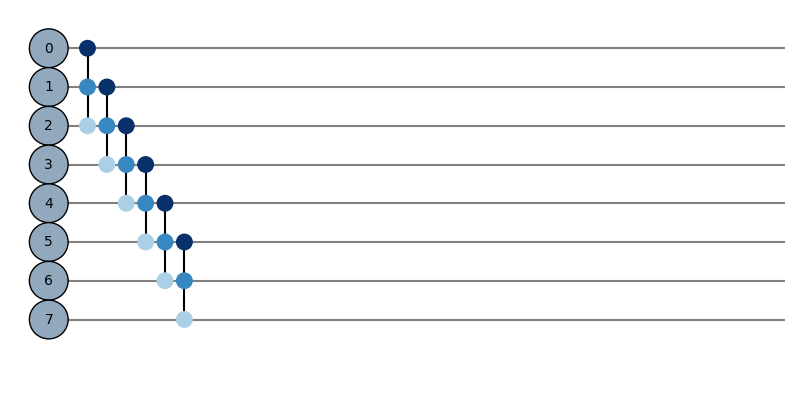

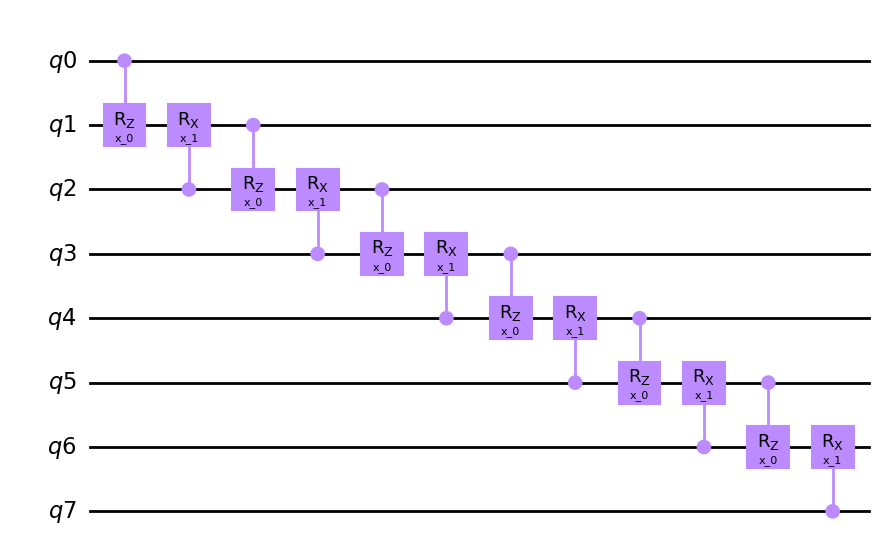

In [24]:
cycle = Qcycle(stride=1, step=1,offset=0, mapping=u3, boundary="open")
cycle = Qinit(8) + cycle
plot_circuit(cycle)
circuit = get_circuit(cycle)
draw_circuit(circuit)

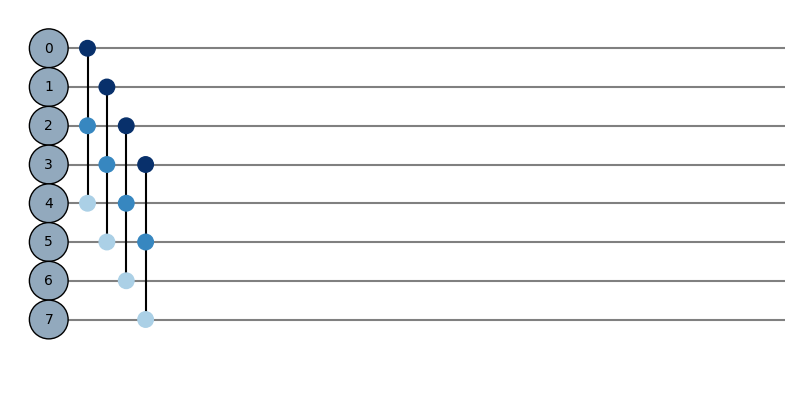

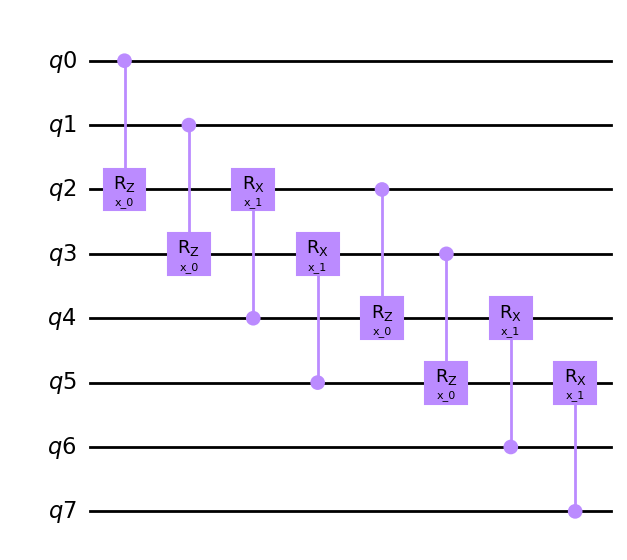

In [25]:
cycle = Qcycle(stride=2, step=1,offset=0, mapping=u3, boundary="open")
cycle = Qinit(8) + cycle
plot_circuit(cycle)
circuit = get_circuit(cycle)
draw_circuit(circuit)

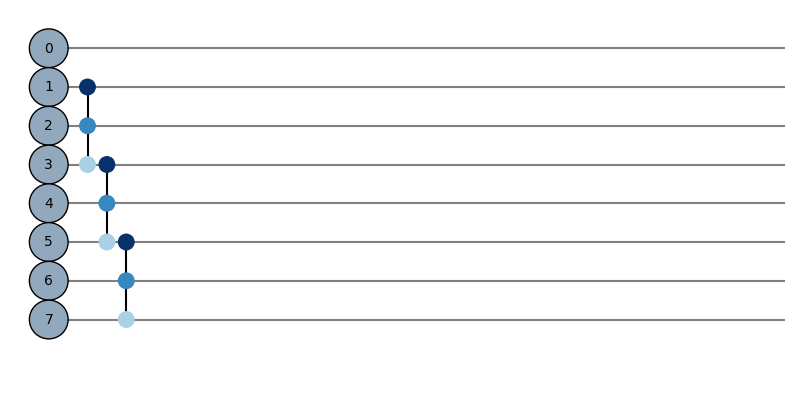

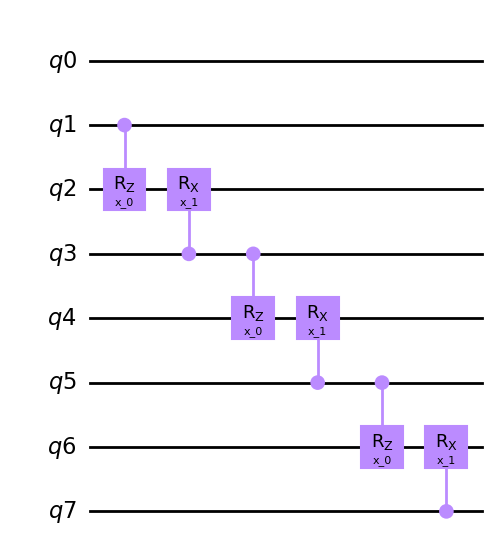

In [26]:
cycle = Qcycle(stride=1, step=2,offset=1, mapping=u3, boundary="open")
cycle = Qinit(8) + cycle
plot_circuit(cycle)
circuit = get_circuit(cycle)
draw_circuit(circuit)

### Qpermute primitive
`Qpermute` is a simple primitive that generates all combinations or permutations of edges based on the `combinations` hyperparameter and `arity` of corresponding function:
```python
if self.combinations:
    E = list(it.combinations(Q, r=self.arity))
else:
    E = list(it.permutations(Q, r=self.arity))
```
Where E is the generated edges and Q the available qubits of the primitive

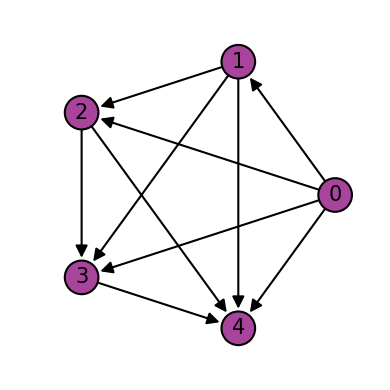

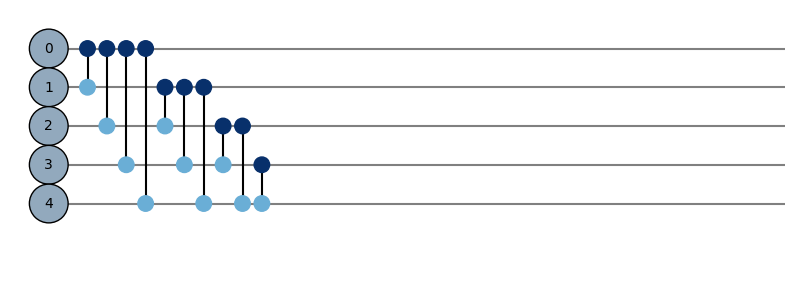

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [27]:
permute = Qpermute()
permute_5_qubits = Qinit(5) + permute
plot_motif(permute_5_qubits[1])
plot_circuit(permute_5_qubits)

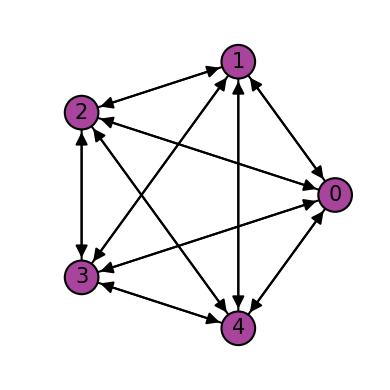

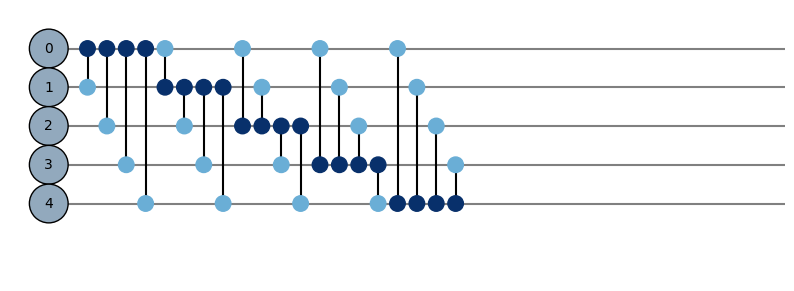

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [28]:
permute = Qpermute(combinations=False)
permute_5_qubits = Qinit(5) + permute
plot_motif(permute_5_qubits[1])
plot_circuit(permute_5_qubits)

In [29]:
permute = Qpermute(combinations=False, mapping=u2_3)
permute_5_qubits = Qinit(5) + permute
print(permute_5_qubits[1].E)

[(0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 2, 1), (0, 2, 3), (0, 2, 4), (0, 3, 1), (0, 3, 2), (0, 3, 4), (0, 4, 1), (0, 4, 2), (0, 4, 3), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 2, 0), (1, 2, 3), (1, 2, 4), (1, 3, 0), (1, 3, 2), (1, 3, 4), (1, 4, 0), (1, 4, 2), (1, 4, 3), (2, 0, 1), (2, 0, 3), (2, 0, 4), (2, 1, 0), (2, 1, 3), (2, 1, 4), (2, 3, 0), (2, 3, 1), (2, 3, 4), (2, 4, 0), (2, 4, 1), (2, 4, 3), (3, 0, 1), (3, 0, 2), (3, 0, 4), (3, 1, 0), (3, 1, 2), (3, 1, 4), (3, 2, 0), (3, 2, 1), (3, 2, 4), (3, 4, 0), (3, 4, 1), (3, 4, 2), (4, 0, 1), (4, 0, 2), (4, 0, 3), (4, 1, 0), (4, 1, 2), (4, 1, 3), (4, 2, 0), (4, 2, 1), (4, 2, 3), (4, 3, 0), (4, 3, 1), (4, 3, 2)]


### Qmask and Qunmask primitive

The `Qmask` primitive allows you to "mask" qubits according to a chosen pattern. Masking qubits in this context implies rendering certain qubits temporarily unavailable for subsequent operations, which facilitates specialized architectures and computations. You have the option to associate a unitary operation with the mask. The utility of this is that it "preserves" the information of the masked qubits, usually through a controlled unitary operation. This feature enables patterns of pooling in quantum neural networks, coarse graining,  entanglers and "deferred measurement" where masked qubits are the controls of unmasked ones.

For 2-qubit unitaries there are predefined masking patterns such as "right", "left", "inside", "outside", "even", "odd" which halves the circuit size. Alternatively, you can provide your own string such as "1\*1" where '1' signifies mask and "*" means to fill with 0's based on the number of available qubits. '0' signifies keeping the qubit active.

When specifying a unitary, there are three `connection_type` options (how to generate the edges):
  - "cycle", simlar to the cycle primitive, generate edges with a stride, step and offset parameter
  - "nearest_circle" connect each masked qubit to the nearest available qubit in a circular topology
  - "nearest_tower"  connect each masked qubit to the nearest available qubit in a tower topology

The Qunmask primitive allows you to "unmask" previously masked qubits, making them available for subsequent operations.

Examples will make this clearer:

#### Masking without a mapping
The small nodes are the masked ones

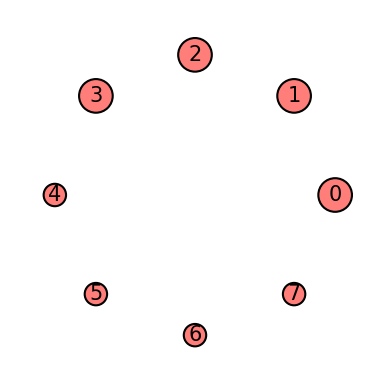

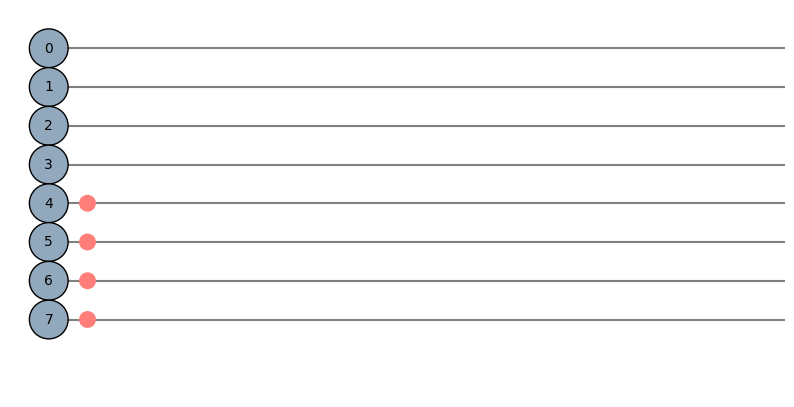

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [30]:
mask = Qinit(8) + Qmask("right")
plot_motif(mask[1])
plot_circuit(mask)

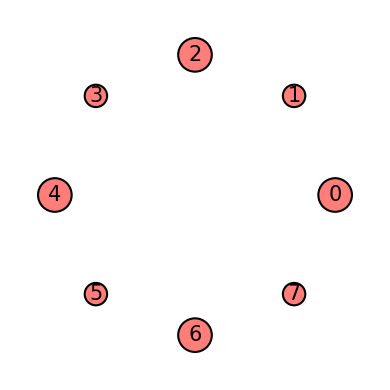

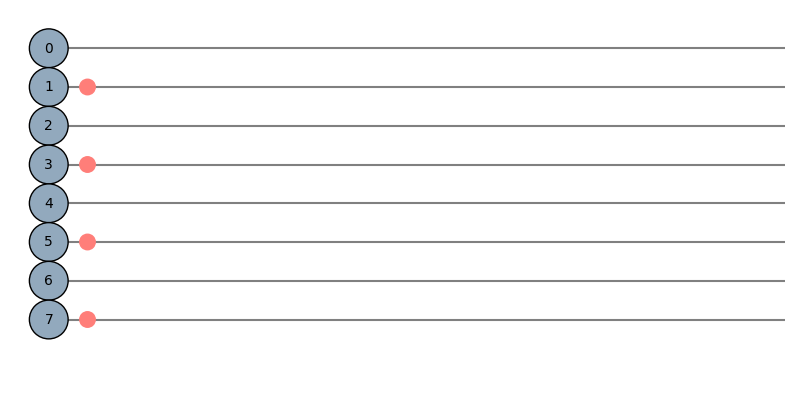

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [31]:
mask = Qinit(8) + Qmask("01")
plot_motif(mask[1])
plot_circuit(mask)

This might be easier to see with a circuit and a mask between two cycles. We'll use the following 2 qubit unitaries for the cycles:

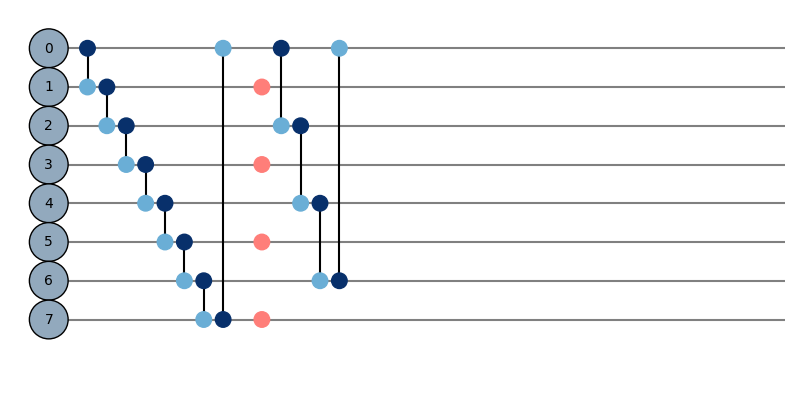

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [32]:
mask = Qinit(8) + Qcycle(mapping=u0_2) + Qmask("01") + Qcycle(mapping=u0_2)
plot_circuit(mask)

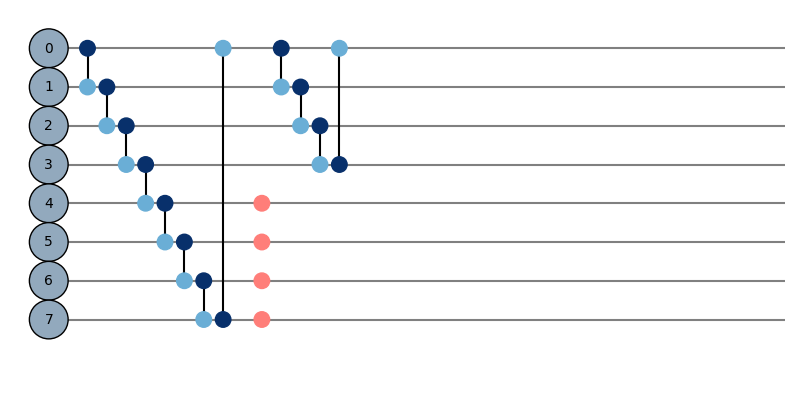

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [33]:
mask = Qinit(8) + Qcycle(mapping=u0_2) + Qmask("right") + Qcycle(mapping=u0_2)
plot_circuit(mask)

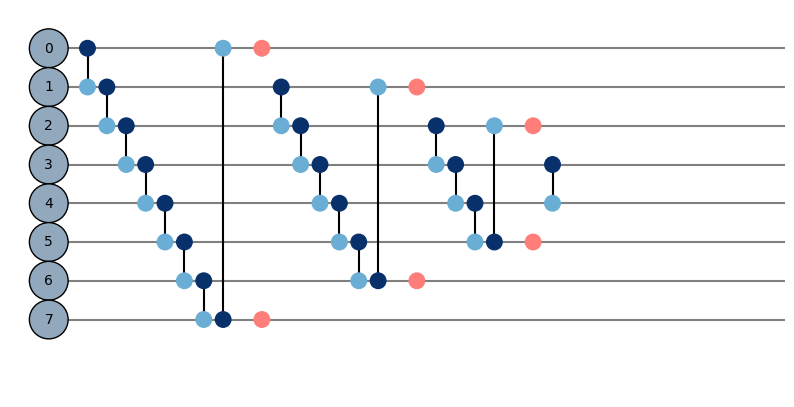

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [34]:
mask = Qinit(8) + Qcycle(mapping=u0_2) + (Qmask("1*1") + Qcycle(mapping=u0_2))*3
plot_circuit(mask)

#### Masking with a mapping

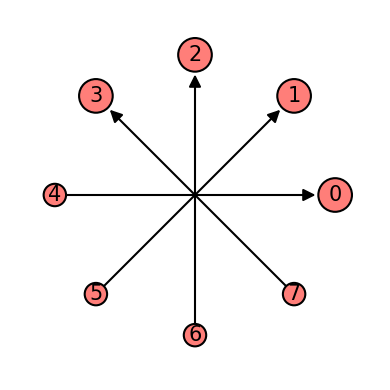

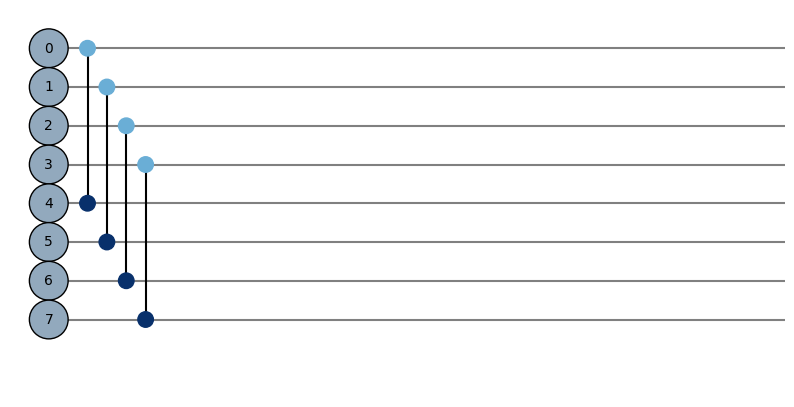

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [35]:
mask = Qinit(8) + Qmask("right", mapping=u0_2)
plot_motif(mask[1])
plot_circuit(mask)

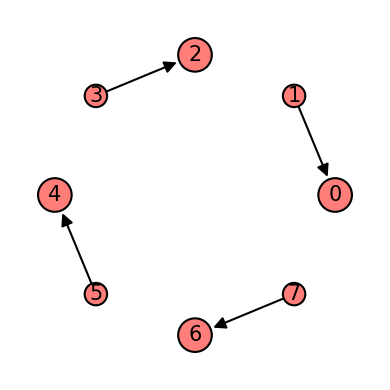

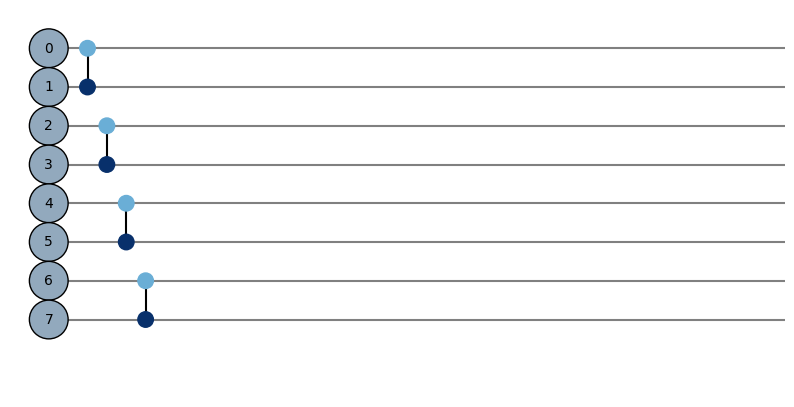

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [36]:
mask = Qinit(8) + Qmask("01", mapping=u0_2)
plot_motif(mask[1])
plot_circuit(mask)

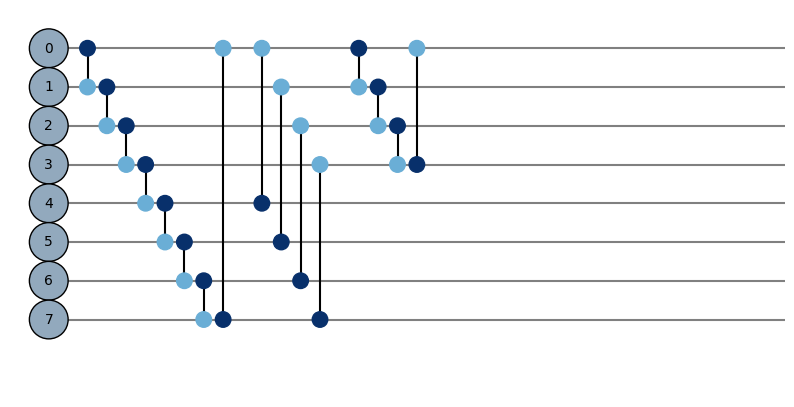

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [37]:
mask = Qinit(8) + Qcycle(mapping=u0_2) + Qmask("*!", mapping=u0_2) + Qcycle(mapping=u0_2)
plot_circuit(mask)

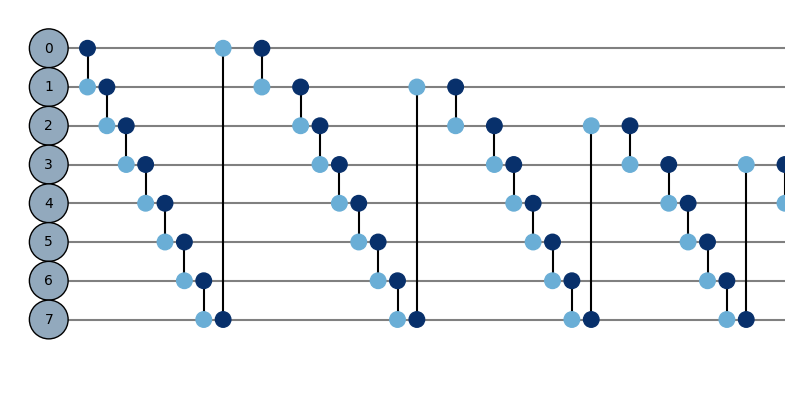

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [38]:
mask = Qinit(8) + Qcycle(mapping=u0_2) + (Qmask("1*", mapping=u0_2) + Qcycle(mapping=u0_2))*6
plot_circuit(mask, depth=30)

#### N-qubit unitaries
For N qubit unitaries, the pattern provided applies within the unitary. For example a pattern of "101" means for each edge of the form (a,b,c), a and c are going to be masked. Therefore the pattern string needs to be the same length as the arity for N>2 unitaries.

In [39]:
if backend == "qiskit":
    from qiskit.circuit import QuantumRegister
    def V3(bits, symbols=None, circuit=None, **kwargs):
        q0, q1, q2 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1]), QuantumRegister(1, bits[2])
        circuit.cnot(q0, q1)
        circuit.cnot(q2, q1)
        return circuit

elif backend == "cirq":
    import cirq
    def V3(bits, symbols=None, circuit=None):
        q0, q1, q2 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1]), cirq.LineQubit(bits[2])
        circuit += cirq.CNOT(q1, q0)
        circuit += cirq.CNOT(q1, q2)
        return circuit

elif backend == "pennylane":
    def V3(bits, symbols=None):
        qml.CNOT(wires=[bits[0], bits[1]])
        qml.CNOT(wires=[bits[2], bits[1]])
v3 = Qunitary(V3, 0, 3)

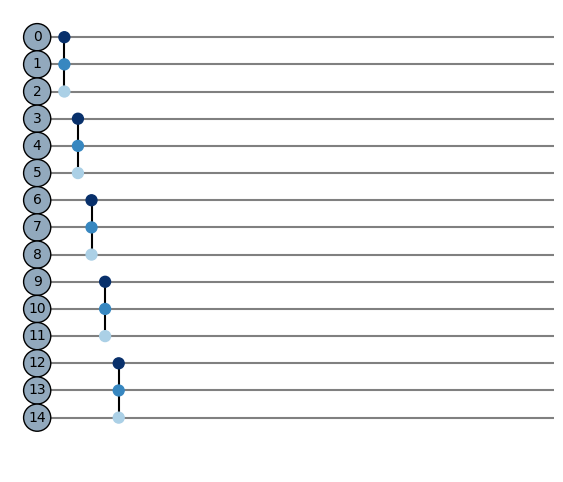

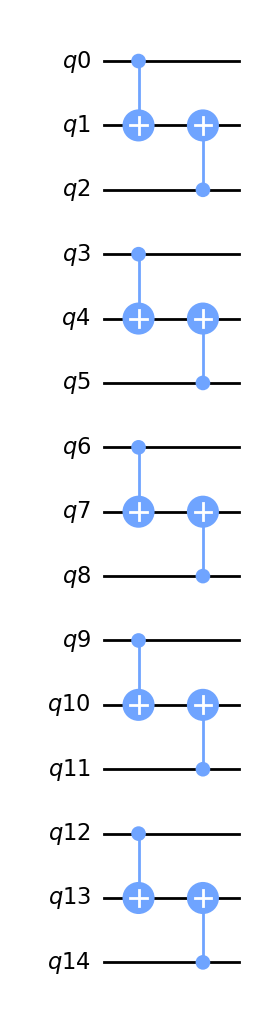

In [40]:
mask = Qinit(15) + Qmask(global_pattern="101",merge_within="101", strides=[1,0,0], steps=[2,1,1], offsets=[0,0,0], mapping=v3)
plot_circuit(mask)
circuit = get_circuit(mask)
draw_circuit(circuit)

#### Qunmask example

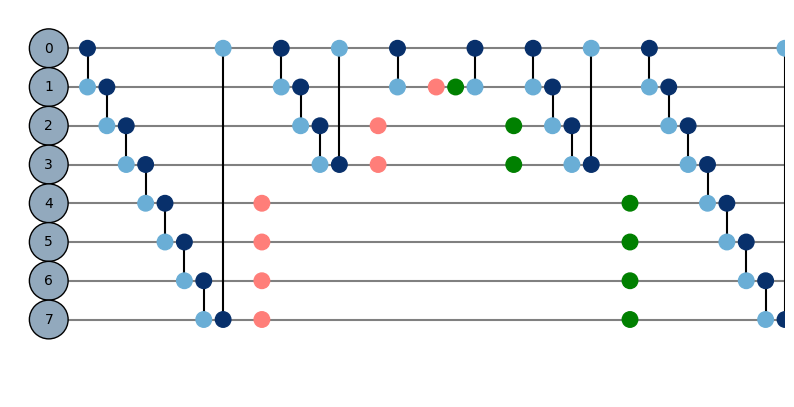

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [41]:
hierq = Qinit(8) + (Qcycle(1, 1, 0, mapping=u0_2) + Qmask("*!"))*3 + (Qunmask("previous") + Qcycle(1, 1, 0, mapping=u0_2))*3
plot_circuit(hierq, depth=25)

## Qpivot primitive

Qpivot is new, and this part of the tutorial will still get fleshed out. The pivot primitve connects the set of available qubits sequentially to a fixed set of qubits. The global pattern determines the pivot points while the merge pattern determines how the qubits are passed to the mapping. For detailed usage please see the grover and qft tutorials. Here are some quick examples:

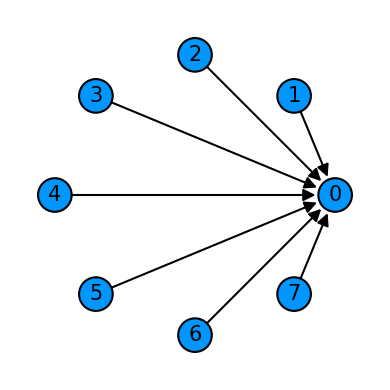

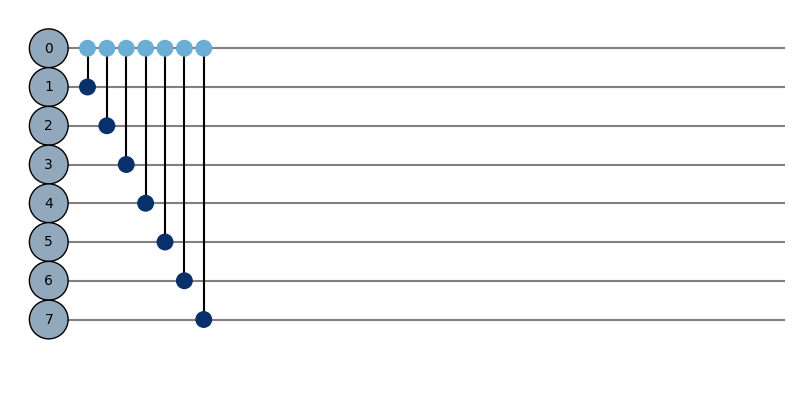

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [42]:
hierq = Qinit(8) + Qpivot(
    global_pattern="1*",
    merge_within="*1",
    merge_between=None,
    strides=[1, 1, 0],
    steps=[1, 1, 1],
    offsets=[0, 0, 0],
    boundaries=["open", "open", "periodic"],
    mapping=u1_2)
plot_motif(hierq[1])
plot_circuit(hierq)

## Classical and Quantum computation (Advanced usage + experimental features)

At the end of the day we are just building a compute graph in a hierarchichal manner with these primitves. For this reason we aren't limited to quantum computation and can create classical algorithms also. This section will show how this can be achieved. We'll also show how a naive quantum state vector simulation can be performed. 


### Classical computation (addition example)

Here is a completely classical computation for arbitrary integer addition. Notice we define two functions (half_adder and or_top) which changes a `state` variable directly (no matrix multiplication, just logic and overwriting, similar to classical circuits). The state is initialised with Qinit, then hierarqcal just executes these functions in the correct order. So you can create any function that changes the `state` as you desire.

In [51]:
def half_adder(bits, symbols=None, state=None):
    b1, b2 = state[bits[0]], state[bits[1]]
    xor = b1 ^ b2
    carry = b1 and b2
    state[bits[0]] = carry
    state[bits[1]] = xor
    return state


def or_top(bits, symbols=None, state=None):
    b1, b2 = state[bits[0]], state[bits[1]]
    state[bits[0]] = b1 or b2
    return state

In [52]:
x = [int(b) for b in bin(np.random.randint(0,512))[2:]]
y = [int(b) for b in bin(np.random.randint(0,512))[2:]]
bits = max(len(x),len(y))
n = 2 * bits
x = [0]*(bits - len(x)) + x
y = [0]*(bits - len(y)) + y

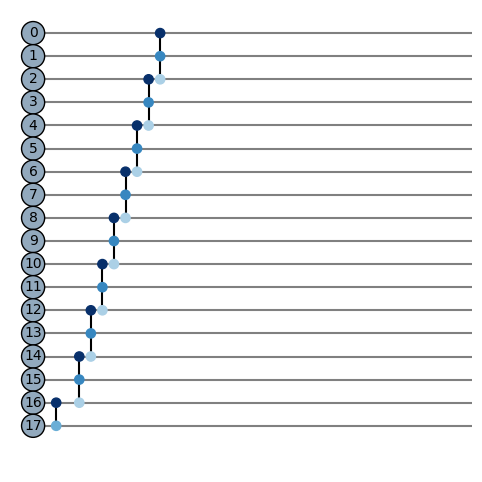

(<Figure size 1000x600 with 1 Axes>, <AxesSubplot:>)

In [53]:
# program
full_adder = (
    Qinit(3)
    + Qcycle(mapping=Qunitary(half_adder, 0, 2), boundary="open")
    + Qpivot(global_pattern="1*", merge_within="11", mapping=Qunitary(or_top, 0, 2))
)
addition = (
    Qinit([i for i in range(n)], state=[elem for pair in zip(x, y) for elem in pair])
    + Qpivot("*1", "11", mapping=Qunitary(half_adder, 0, 2))
    + Qcycle(step=2, edge_order=[-1], mapping=full_adder, boundary="open")
)
plot_circuit(addition)

In [54]:
# Get the answer, we generate a bitstring and then turn it into a function that return only the array items with corresponding index 1
# Qsplit is a lower level primitve that Qmask and Qpivot inherhtis from, the bitstrings we generate for them also gets turned into functions via get_pattern_fn
# Don't run this twice! then you won't get the correct answer
b = addition()
pattern_fn = Qsplit.get_pattern_fn(
    None, pattern="1" + "01" * (int(n / 2) - 1) + "1", length=n
)
z = pattern_fn(b)

In [55]:
print(
    f"""
        {sum([x[i]*2**((len(x)-1)-i) for i in range(len(x))])}
        +
        {sum([y[i]*2**((len(y)-1)-i) for i in range(len(y))])}
        =
        {sum([z[i]*2**((len(z)-1)-i) for i in range(len(z))])}
    """
)


        18
        +
        342
        =
        360
    


### Lower level control (create your own edge patterns) + custom Quantum simulation

Below we are show two things at the same time, first how you can specify individual edges to the `Qmotif` primitive. Depending on the `arity`, `E` is a list of `arity`-tuples which you can generate. For example `E=[(0,2,4),(1,3,5)]` means your `Qunitary` function takes 3 inputs (`arity`=3) and will apply the function to `bits` 0,2,4 and 1,3,5 seperatly, in the order that's provided. This will works for 3rd party quantum packages (so you can do this with Qiskit, Cirq, or Pennylane). We're combining this with a custom circuit simulation where we perform tensor contraction to calculate the final state vector. This way it's possible to simulate qutrits, qudits or even more general tensor networks.

This is a quick demonstration, for details check out `Qhierarchy.__call__` method in `core.py` and `get_tensor_as_f` in `utils.py`

The code below creates a Toffoli gate, we apply two bitflips on the first two qubits to see if the third will be flipped.

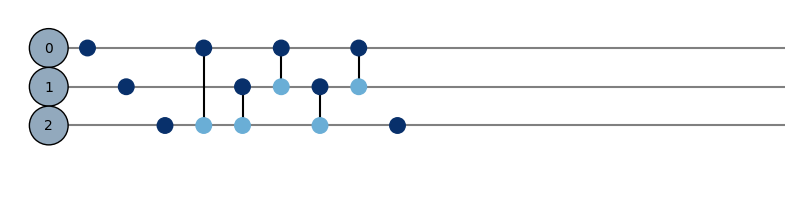

[0.+0.000000e+00j 0.+0.000000e+00j 0.+0.000000e+00j 0.+0.000000e+00j
 0.+0.000000e+00j 0.+0.000000e+00j 0.+6.123234e-17j 1.-6.123234e-17j]


In [56]:
from hierarqcal import get_tensor_as_f
H_m = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
X_m = np.array([[0, 1], [1, 0]])
CN_m = sp.Matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
x0 = sp.symbols("x")
CP_m = sp.Matrix(
    [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, sp.exp(sp.I * x0)]]
)
H = Qunitary(get_tensor_as_f(H_m), 0, 1)
X = Qunitary(get_tensor_as_f(X_m), 0, 1)
CP = Qunitary(get_tensor_as_f(CP_m), 1, 2)
CN = Qunitary(get_tensor_as_f(CN_m), 0, 2)

tensors = [np.array([1, 0], dtype=np.complex256)] * 3
hierq = (
    Qinit([i for i in range(3)], tensors=tensors)
    + Qmotif(E=[(0,)], mapping=X)
    + Qmotif(E=[(1,)], mapping=X)
    + Qmotif(E=[(2,)], mapping=H)
    + Qmotif(E=[(0,2)], mapping=Qunitary(get_tensor_as_f(CP_m), symbols=[np.pi/2], arity=2))
    + Qmotif(E=[(1,2)], mapping=Qunitary(get_tensor_as_f(CP_m), symbols=[np.pi/2], arity=2))
    + Qmotif(E=[(0,1)], mapping=Qunitary(get_tensor_as_f(CN_m), arity=2))
    + Qmotif(E=[(1,2)], mapping=Qunitary(get_tensor_as_f(CP_m), symbols=[-np.pi/2], arity=2))
    + Qmotif(E=[(0,1)], mapping=Qunitary(get_tensor_as_f(CN_m), arity=2))
    + Qmotif(E=[(2,)], mapping=H)
)

plot_circuit(hierq)
print(hierq().flatten())